## Uses the old simout structure, so don't use this

In [1]:
import sys
## Set the path so MESS will run. You _shouldn't_ have to do thist.
sys.path = ['', '/home/isaac/miniconda2/envs/MESS/lib/python27.zip', 
            '/home/isaac/miniconda2/envs/MESS/lib/python2.7', 
            '/home/isaac/miniconda2/envs/MESS/lib/python2.7/plat-linux2', 
            '/home/isaac/miniconda2/envs/MESS/lib/python2.7/lib-tk', 
            '/home/isaac/miniconda2/envs/MESS/lib/python2.7/lib-old', 
            '/home/isaac/miniconda2/envs/MESS/lib/python2.7/lib-dynload', 
            '/home/isaac/miniconda2/envs/MESS/lib/python2.7/site-packages', 
            '/home/isaac/miniconda2/envs/MESS/lib/python2.7/site-packages/DendroPy-4.2.0-py2.7.egg', 
            '/home/isaac/easyCGD', '/home/isaac/Continuosity/MESS']


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
import ipyparallel as ipp
import pandas as pd
import numpy as np
import os
import seaborn as sns
from IPython.display import display

import MESS
from MESS.util import set_params

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

analysis_dir = "/home/isaac/Continuosity/MESS/analysis/"
analysis_dir = analysis_dir + "/evolved-vs-assembled/"

In [4]:
MESS.LocalCommunity()

In [5]:
r = MESS.Region("r1")
r.paramsdict["generations"] = 0.25
r.set_param("project_dir", analysis_dir)
r.set_param("m", 0.01)
r.run(sims=1)


  Project directory exists. Additional simulations will be appended.
    Generating 1 simulation(s).
  [####################] 100%  Finished 0 simulations    | 0:00:00 | 
 

`ipcluster start -n 40 --cluster-id="MESS-Rich" --daemonize`

In [7]:
ipyclient = ipp.Client(cluster_id="MESS-Rich")
print(len(ipyclient))

40


In [11]:
_lambdas = [0.1, 0.25, 0.5, 0.75, 1.0]

colrates = np.array([0.05, 0.01, 0.005, 0.001, 0.0005])
specrates = colrates/10

params = [_lambdas, colrates, specrates]
params = list(itertools.product(*params))
for i, p in enumerate(params):
    _lambda, colrate, specrate = p
    print(_lambda, colrate, specrate)
    ldir = analysis_dir + "evolved-vs-assembled-lambda-{}/".format(_lambda)
    if not os.path.exists(ldir):
        os.mkdir(ldir)
    r = MESS.Region("sim-{}".format(i))
    r._log_files = True
    r.set_param("generations", _lambda)
    r.set_param("m", colrate)
    r.set_param("speciation_rate", specrate)
    r.set_param("project_dir", ldir)
    r.set_param("J", 5000)
    r.run(sims=40, ipyclient=ipyclient, quiet=True)

(0.1, 0.05, 0.005)
  Project directory exists. Additional simulations will be appended.

(0.1, 0.05, 0.001)
  Project directory exists. Additional simulations will be appended.

(0.1, 0.05, 0.0005)
  Project directory exists. Additional simulations will be appended.

(0.1, 0.05, 0.0001)
  Project directory exists. Additional simulations will be appended.

(0.1, 0.05, 5e-05)
  Project directory exists. Additional simulations will be appended.

(0.1, 0.01, 0.005)
  Project directory exists. Additional simulations will be appended.

(0.1, 0.01, 0.001)
  Project directory exists. Additional simulations will be appended.

(0.1, 0.01, 0.0005)
  Project directory exists. Additional simulations will be appended.

(0.1, 0.01, 0.0001)
  Project directory exists. Additional simulations will be appended.

(0.1, 0.01, 5e-05)
  Project directory exists. Additional simulations will be appended.

(0.1, 0.005, 0.005)
  Project directory exists. Additional simulations will be appended.

(0.1, 0.005, 0.0


(0.75, 0.001, 0.001)
  Project directory exists. Additional simulations will be appended.

(0.75, 0.001, 0.0005)
  Project directory exists. Additional simulations will be appended.

(0.75, 0.001, 0.0001)
  Project directory exists. Additional simulations will be appended.

(0.75, 0.001, 5e-05)
  Project directory exists. Additional simulations will be appended.

(0.75, 0.0005, 0.005)
  Project directory exists. Additional simulations will be appended.

(0.75, 0.0005, 0.001)
  Project directory exists. Additional simulations will be appended.

(0.75, 0.0005, 0.0005)
  Project directory exists. Additional simulations will be appended.

(0.75, 0.0005, 0.0001)
  Project directory exists. Additional simulations will be appended.

(0.75, 0.0005, 5e-05)
  Project directory exists. Additional simulations will be appended.

(1.0, 0.05, 0.005)
  Project directory exists. Additional simulations will be appended.

(1.0, 0.05, 0.001)
  Project directory exists. Additional simulations will be appe

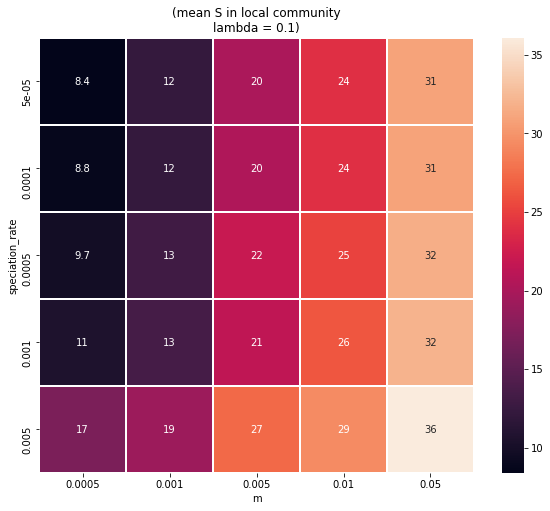

In [18]:
## Might experiment with prettying up the plot a little
## https://seaborn.pydata.org/generated/seaborn.heatmap.html

## This version works for the file structure of the colrate
## vs Sm simulations where each Sm had it's own directory.
def plot_local_richness_sims(ldir, params=["m", "speciation_rate"],\
                             target="S", stat=np.mean, verbose=False, log=True, ax=None):
    p0 = params[0]
    p1 = params[1]
    _lambda = ldir.rsplit("/", 1)[0].split("-")[-1]
    sim_df = pd.read_csv(ldir + "/SIMOUT.txt", sep="\t", header=0)

    ## Get range of param values for each param
    p_dict = {}
    for p in params:
        p_dict[p] = sorted(list(set(sim_df[p])))

    if log: log_fn = np.log
    else: log_fn = lambda x: x

    ## Get ln() for the mean and std of the target output for
    ## each value of the input parameters, and construct the matrix of values
    stat_df = pd.DataFrame([], columns=p_dict[p0], index=p_dict[p1], dtype=float)

    for param_comb in list(itertools.product(p_dict[p0], p_dict[p1])):
        col, row = param_comb
        ## Get a mask for each of the parameter values and apply the mask to the sim_df
        ## Get just the rows we're interested in for this parameter combination
        m1 = sim_df[p0] == col
        m2 = sim_df[p1] == row
        df = sim_df[m1 & m2]

        ## Can prepend the *_h* params with "scaled" and itll scale hill by richness
        if "scaled" in target:
            try:
                tar = target.split("_", 1)[1]
            except:
                print("If scaling by richness must prepend `scale_` exactly - {}".format(param))
            res = stat(log_fn(df[tar]/df["S"]))
        else:
            res = stat(log_fn(df[target]))

        stat_df[col][row] = res
    if verbose: display(stat_df)

    ## Plot the heatmap

    if not ax:
        fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(stat_df, annot=True, ax=ax, square=True, linewidth=0.5)
    _ = ax.set_xlabel(p0)
    _ = ax.set_ylabel(p1)
    _ = ax.set_title("({} {} in local community\nlambda = {})".format(stat.func_name, target, _lambda))
    return ax
ax = plot_local_richness_sims(analysis_dir+"/evolved-vs-assembled-lambda-0.1/", log=False, verbose=False)


In [17]:
_lambdas = [0.1, 0.25, 0.5, 0.75, 1.0]
fig_dir = analysis_dir + "evolved-vs-assembled-figures/"
if not os.path.exists(fig_dir): os.mkdir(fig_dir)
pre = analysis_dir + "evolved-vs-assembled-lambda-{}/"

def plot_six_panel(params=["m", "speciation_rate"],\
                   target="S", log="True", save=True, show=True):
    fig, axs = plt.subplots(2, 3, figsize=(15, 7))
    axs = [ax for sublist in axs for ax in sublist]

    for ax, _lambda in zip(axs, _lambdas):
        try:
            plot_local_richness_sims(ldir=pre.format(_lambda),\
                                    params=params, target=target, stat=np.mean,\
                                    ax=ax, log=log, verbose=False)
        except Exception as inst:
            print(_lambda, inst)
    plt.tight_layout()
    if save: plt.savefig(fig_dir + target + ".png")
    if not show: plt.close()
targets = ['S', 'abund_h1', 'abund_h2', 'abund_h3', 'pi_h1', 'pi_h2', 'pi_h3',\
         'scaled_abund_h1', 'scaled_abund_h2', 'scaled_abund_h3',\
          'scaled_pi_h1', 'scaled_pi_h2', 'scaled_pi_h3']
for tar in targets:
    if "scaled" in tar: log = False
    else: log = True
    plot_six_panel(target=tar, log=log, show=False)

# Below here is dev

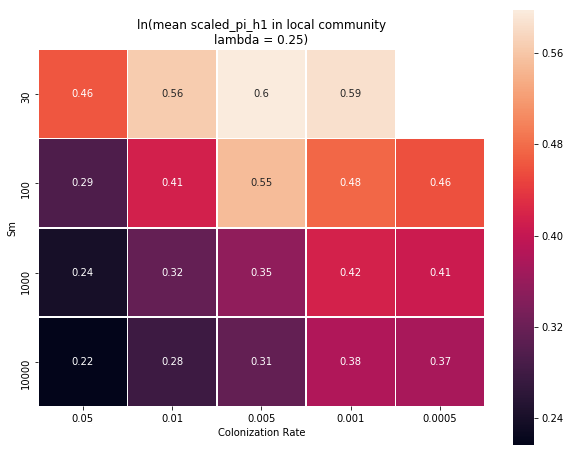

In [250]:
## Might experiment with prettying up the plot a little
## https://seaborn.pydata.org/generated/seaborn.heatmap.html

## This version works for the file structure of the colrate
## vs Sm simulations where each Sm had it's own directory.
## Abandoning this in favor of having all params in  the simout
## file, but hanging on to it for now because it used to work.
def plot_local_richness_sims(_lambda=0.5, param="S", stat="mean", verbose=False, log=True, ax=None):
    ## Read in all the SIMOUT files in to dataframes for each value of Sm
    Sm_dict = {}
    ldir = analysis_dir + "richness-horserace-lambda-{}/".format(_lambda)
    for Sm in Sms:
        #if verbose: print(Sm)
        df = pd.read_csv(ldir + "richness-horserace-Sm-{}/SIMOUT.txt".format(Sm), sep="\t", header=0)
        #if verbose: display(df)
        Sm_dict[Sm] = df

    if log: log_fn = np.log
    else: log_fn = lambda x: x

    ## Get ln() for the mean and std of local species richness for
    ## each value of Sm and c, and construct the matrix of values
    mean_df = pd.DataFrame([])
    std_df = pd.DataFrame([])
    for Sm in Sms:
        df = Sm_dict[Sm]
        tmpm = []
        tmpv = []
        for i, c in enumerate(cs):
            _min = i*10
            _max = (i+1)*10

            ## Can prepend the *_h* params with "scaled" and itll scale hill by richness
            if "scaled" in param:
                try:
                    par = param.split("_", 1)[1]
                except:
                    print("If scaling by richness must prepend `scale_` exactly - {}".format(param))
                tmpm.append((log_fn(df[par][_min:_max]/df["S"][_min:_max]).mean()))
                tmpv.append((log_fn(df[par][_min:_max]/df["S"][_min:_max]).std()))  
            else:
                tmpm.append(log_fn(df[param][_min:_max].mean()))
                tmpv.append(log_fn(df[param][_min:_max].std()))
        mean_df = mean_df.append(pd.DataFrame(tmpm, columns=[Sm], index=cs).T, ignore_index=False)
        std_df = std_df.append(pd.DataFrame(tmpv, columns=[Sm], index=cs).T, ignore_index=False)
    if verbose: display(mean_df)
    if verbose: display(std_df)

    ## Plot the heatmap
    if stat == "mean": df = mean_df
    elif stat == "std": df = std_df
    else: print("Unrecognized stat - {}".format(stat))

    if not ax:
        fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(df, annot=True, ax=ax, square=True, linewidth=0.5)
    _ = ax.set_xlabel("Colonization Rate")
    _ = ax.set_ylabel("Sm")
    _ = ax.set_title("ln({} {} in local community\nlambda = {})".format(stat, param, _lambda))
    return ax
_ = plot_local_richness_sims(_lambda=0.25, param="scaled_pi_h1", log=False, verbose=False)

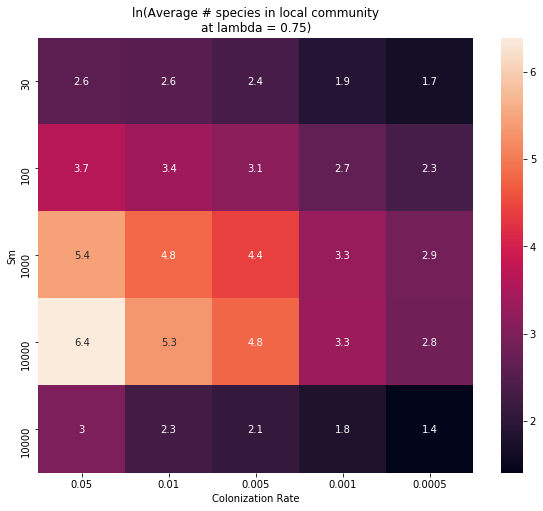

In [186]:
## Looks like shit
#mean_df.style.background_gradient(cmap='magma')
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(std_df, annot=True, ax=ax, square=True)
_ = ax.set_xlabel("Colonization Rate")
_ = ax.set_ylabel("Sm")
_ = ax.set_title("ln(Average # species in local community\nat lambda = 0.75)")

In [22]:
df = pd.read_csv("/home/isaac/Continuosity/MESS/analysis/extreme-parameters/evolved-vs-assembled-lambda-0.25/SIMOUT.txt", sep="\t", header=0)
df[["speciation_rate", "m", "generation", "_lambda"]]

,speciation_rate,m,generation,_lambda
0,0.1000,0.1000,6.0,0.2584
1,0.1000,0.1000,6.0,0.2694
2,0.1000,0.1000,6.0,0.2594
3,0.1000,0.1000,7.0,0.2884
4,0.1000,0.1000,6.0,0.2544
5,0.1000,0.1000,6.0,0.2558
6,0.1000,0.1000,7.0,0.2886
7,0.1000,0.1000,6.0,0.2558
8,0.1000,0.1000,6.0,0.2628
9,0.1000,0.1000,7.0,0.2866


In [25]:
tuple('5')

('5',)